# Realtime ASR without VAD

Let say you want to transcribe realtime recording / input using PyAudio without VAD, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-asr-without-vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-asr-without-vad).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [2]:
import malaya_speech
from malaya_speech import Pipeline

### Streaming interface

```python
def stream(
    vad_model=None,
    asr_model=None,
    classification_model=None,
    sample_rate: int = 16000,
    segment_length: int = 2560,
    num_padding_frames: int = 20,
    ratio: float = 0.75,
    min_length: float = 0.1,
    max_length: float = 10.0,
    realtime_print: bool = True,
    **kwargs,
):
    """
    Stream an audio using pyaudio library.

    Parameters
    ----------
    vad_model: object, optional (default=None)
        vad model / pipeline.
    asr_model: object, optional (default=None)
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object, optional (default=None)
        classification pipeline, will classify each subsamples realtime.
    device: None, optional (default=None)
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    segment_length: int, optional (default=2560)
        usually derived from asr_model.segment_length * asr_model.hop_length,
        size of audio chunks, actual size in term of second is `segment_length` / `sample_rate`.
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (second) to accept a subsample.
    max_length: float, optional (default=10.0)
        maximum length (second) to accept a subsample.
    realtime_print: bool, optional (default=True)
        Will print results for ASR.
    **kwargs: vector argument
        vector argument pass to malaya_speech.streaming.pyaudio.Audio interface.

    Returns
    -------
    result : List[dict]
    """
```

### Check available devices

In [3]:
import sounddevice

sounddevice.query_devices()

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

By default it will use `0` index.

### Load ASR model

In [4]:
malaya_speech.stt.transducer.available_pt_transformer()

,Size (MB),malay-malaya,malay-fleur102,Language,singlish
mesolitica/conformer-tiny,38.5,"{'WER': 0.17341180814, 'CER': 0.05957485024}","{'WER': 0.19524478979, 'CER': 0.0830808938}",[malay],NaN
mesolitica/conformer-base,121,"{'WER': 0.122076123261, 'CER': 0.03879606324}","{'WER': 0.1326737206665, 'CER': 0.05032914857}",[malay],NaN
mesolitica/conformer-medium,243,"{'WER': 0.1054817492564, 'CER': 0.0313518992842}","{'WER': 0.1172708897486, 'CER': 0.0431050488}",[malay],NaN
mesolitica/emformer-base,162,"{'WER': 0.175762423786, 'CER': 0.06233919000537}","{'WER': 0.18303839134, 'CER': 0.0773853362}",[malay],NaN
mesolitica/conformer-base-singlish,121,NaN,NaN,[singlish],"{'WER': 0.06517537334361, 'CER': 0.03265430876}"
mesolitica/conformer-medium-mixed,243,"{'WER': 0.111166517935, 'CER': 0.03410958328}","{'WER': 0.108354748, 'CER': 0.037785722}","[malay, singlish]","{'WER': 0.091969755225, 'CER': 0.044627194623}"
mesolitica/conformer-medium-mixed-augmented,243,"{'WER': 0.1015719878, 'CER': 0.0326360923}","{'WER': 0.1103884742, 'CER': 0.0385676182}","[malay, singlish]","{'WER': 0.086342166, 'CER': 0.0413572066}"
mesolitica/conformer-large-mixed-augmented,413,"{'WER': 0.0919852874, 'CER': 0.026612152}","{'WER': 0.103593636, 'CER': 0.036611048}","[malay, singlish]","{'WER': 0.08727157, 'CER': 0.04318735972}"


In [5]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium')

In [6]:
_ = model.eval()

### ASR Pipeline

Because pyaudio will returned int16 bytes, so we need to change to numpy array then normalize to float, feel free to add speech enhancement or any function, but in this example, I just keep it simple.

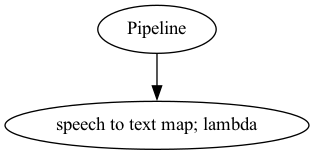

In [8]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(lambda x: model.beam_decoder([x])[0], name = 'speech-to-text')
)
p_asr.visualize()

**You need to make sure the last output should named as `speech-to-text` or else the streaming interface will throw an error**.

### Start Recording

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

**If you are not provide VAD model, make sure `max_length` set to proper value to chunk it**.

In [9]:
samples = malaya_speech.streaming.pyaudio.stream(asr_model = p_asr, max_length = 5.0)

helo nama saya hussein bin kapal anak saya masam isteri saya pun masam semua orang masa terima kasih 

Actually it is pretty nice. As you can see, it able to transcribe realtime, you can try it by yourself.

In [10]:
len(samples)

5

In [11]:
samples[1]

{'wav_data': array([ 0.02063065,  0.02536985,  0.02458022, ..., -0.02863501,
        -0.04477567, -0.07088793], dtype=float32),
 'start': 5.12,
 'asr_model': 'nama saya hussein bin',
 'end': 10.24}

In [12]:
import IPython.display as ipd
import numpy as np

In [13]:
ipd.Audio(samples[1]['wav_data'], rate = 16000)

In [15]:
ipd.Audio(np.concatenate([s['wav_data'] for s in samples[:3]]), rate = 16000)